# Fourier Neural Operator for the Burgers' Equation

This notebook demonstrates the application of the Fourier Neural Operator (FNO), a method developed by Li et al. (2020), to solve the 1D Burgers' equation. The Burgers' equation is a fundamental partial differential equation (PDE) from fluid mechanics that describes the behavior of a viscous fluid.

### Reference
Li, Z., Kovachki, N., Azizzadenesheli, K., Liu, B., Bhattacharya, K., Stuart, A., & Anandkumar, A. (2020). Fourier Neural Operator for Parametric Partial Differential Equations. arXiv preprint arXiv:2010.08895.

### Objective
The primary objective is to learn the operator $G^{\dagger}$ mapping the initial conditions $u(x,0)$ to the state $u(x,t)$ at a future time $t$. This operator encapsulates the solution to the Burgers' equation over a specified time interval.

### Dataset Description
The dataset comprises 2,048 samples, each a solution to the 1D Burgers' equation. Every sample is discretized over 1,024 spatial points uniformly distributed over the interval $x \in [0,1)$.

#### Mathematical Model
The Burgers' equation we focus on is defined as:
$$
\begin{aligned}
\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(\frac{u^2}{2}\right) &= \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [0,1), \, t \in [0,1] \\
u(x, 0) &= u_0(x), \quad x \in [0,1)
\end{aligned}
$$
- $u(x, t)$ represents the fluid velocity.
- $\nu$, the viscosity coefficient, is set to 0.1 for all simulations.
- $u_0(x)$, the initial condition, varies across samples.

#### Boundary and Initial Conditions
- **Boundary Conditions**: The model employs periodic boundary conditions to simulate behavior on a unit torus.
- **Initial Conditions**: Each $u_0(x)$ is sampled from a Gaussian random field:
  $$
  u_0 \sim \mathcal{N}\left(0, 625(-\Delta + 25I)^{-2}\right)
  $$
  - $\Delta$ is the Laplacian operator.
  - $I$ denotes the identity operator, ensuring smooth yet variable initial conditions suitable for dynamic studies.

### Learning Task
The task is to model $G^{\dagger}$: $L_{\text{per}}^2([0,1);\mathbb{R}) \rightarrow H_{\text{per}}^r([0,1);\mathbb{R})$, the map from initial conditions to solutions at $t = 1$, for any $r > 0$. This approach aims to predict fluid dynamics from initial conditions efficiently, bypassing the computationally intensive numerical PDE solutions.

In [6]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import gdown

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


output = 'burgers_2048x1024.mat'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    url = 'https://drive.google.com/uc?export=download&id=1QN6XB5Pok1c1F0VVNqU8mwWodZowL3ZK'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

burgers_2048x1024.mat already exists, skipping download.


## Dataset

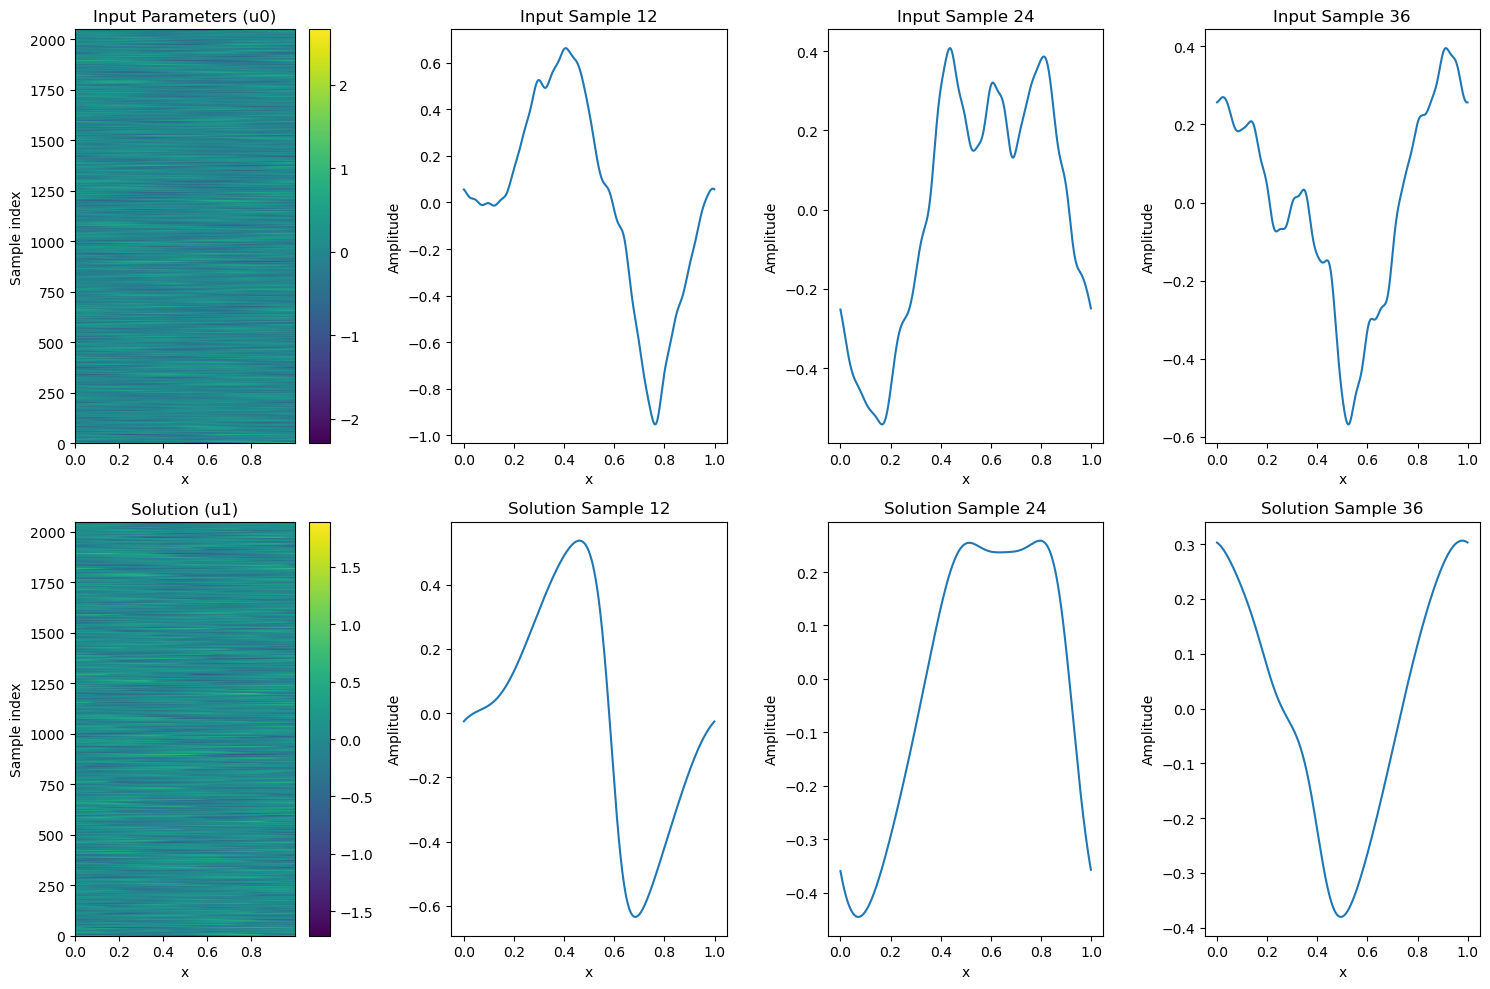

In [7]:
def dataset_summary():
    """
    Create summary plots for the Burgers' equation dataset.
    
    Parameters:
    - data : dict, loaded .mat file containing 'u0', 'u1', 'x'
    - sample_indices : list of int, indices of samples to plot in detail
    """
    data = scipy.io.loadmat('burgers_2048x1024.mat')
    sample_indices = [12, 24, 36]  # Example indices of samples to plot in detail


    # Ensure x is a 1D array for consistent plotting
    x = data['x'].squeeze()  # Squeeze to remove singleton dimensions

    # Prepare the figure with subplots
    fig, axs = plt.subplots(2, len(sample_indices) + 1, figsize=(15, 10))

    # Global view of input parameters and solution
    cax0 = axs[0, 0].imshow(data['u0'], aspect='auto', extent=[x[0], x[-1], 0, data['u0'].shape[0]])
    axs[0, 0].set_title('Input Parameters (u0)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('Sample index')
    fig.colorbar(cax0, ax=axs[0, 0])

    cax1 = axs[1, 0].imshow(data['u1'], aspect='auto', extent=[x[0], x[-1], 0, data['u1'].shape[0]])
    axs[1, 0].set_title('Solution (u1)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('Sample index')
    fig.colorbar(cax1, ax=axs[1, 0])

    # Specific samples detailed view
    for i, index in enumerate(sample_indices):
        # Plot the input sample
        axs[0, i + 1].plot(x, data['u0'][index])
        axs[0, i + 1].set_title(f'Input Sample {index}')
        axs[0, i + 1].set_xlabel('x')
        axs[0, i + 1].set_ylabel('Amplitude')

        # Plot the solution sample
        axs[1, i + 1].plot(x, data['u1'][index])
        axs[1, i + 1].set_title(f'Solution Sample {index}')
        axs[1, i + 1].set_xlabel('x')
        axs[1, i + 1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

dataset_summary()

## Model
The Neural Operator, proposed by [Li et al., 2020](https://arxiv.org/abs/2003.03485), offers a novel approach to function approximation challenges. Let's dive into the architecture and principles behind this innovative technique.

### Definition and Formulation

The Neural Operator is conceived as an iterative sequence, illustrated as $ v_0 \mapsto v_1 \mapsto \ldots \mapsto v_T $, where each $ v_j $ for $ j = 0, 1, \ldots, T - 1 $ represents a series of functions that take values in $ \mathbb{R}^{d_v} $.

The procedure begins with the input $ a \in A $ being elevated to a superior dimensional representation through:

$$ v_0(x) = P(a(x)) $$

This is achieved by the local transformation $ P $, typically realized using a shallow, fully-connected neural network.

Subsequent steps involve several iterations of updates from $ v_t $ to $ v_{t+1} $. The final output, $ u(x) = Q(v_T(x)) $, emerges as a projection of $ v_T $ by a local transformation defined as:

$$ Q : \mathbb{R}^{d_v} \rightarrow \mathbb{R}^{d_u} $$

Each iteration is characterized by a combination of a non-local integral operator $ K $ and a local, nonlinear activation function $ \sigma $.

### Iterative Updates

The transformation from $ v_t $ to $ v_{t+1} $ is formally represented as:

$$ v_{t+1}(x) = \sigma \left( W v_t(x) + K(a; \phi) v_t(x) \right) $$

Where:

- $ K : A \times \Theta_K \rightarrow L(U(D; \mathbb{R}^{d_v}), U(D; \mathbb{R}^{d_v})) $ maps to bounded linear operators on $ U(D; \mathbb{R}^{d_v}) $ and is parameterized by $ \phi \in \Theta_K $.
- $ W : \mathbb{R}^{d_v} \rightarrow \mathbb{R}^{d_v} $ is a linear transformation.
- $ \sigma : \mathbb{R} \rightarrow \mathbb{R} $ is a nonlinear activation function operating component-wise.

#### Kernel Integral Operator

The kernel integral operator in the update process is defined as:

$$\big(K(a; \phi) v_t \big)(x) := \int_D \kappa(x, y, a(x), a(y); \phi) v_t(y) \, dy, \forall x \in D$$
where $k_{\phi}: \mathbb{R}^{2(d+d_a)} \to \mathbb{R}^{d_v \times d_v}$ is a neural network parameterized by $\phi \in \Theta_K$.


### Fourier Neural Operator
We propose replacing the kernel integral operator in (3), by a convolution operator defined in Fourier space. Let $ F $ denote the Fourier transform of a function $ f : D \rightarrow \mathbb{R}^{d_v} $ and $ F^{-1} $ its inverse, then
\begin{align}
(Ff)_j(k) &= \int_D f_j(x) e^{-2i\pi \langle k, x \rangle} \, dx \\ 
(F^{-1}f)_j(x) &= \int_D f_j(k) e^{2i\pi \langle k, x \rangle} \, dk
\end{align}
for $ j = 1, \ldots, d_v $, where $ i = \sqrt{-1} $ is the imaginary unit. By letting $ \kappa_\phi(x, y, a(x), a(y)) = \kappa_\phi(x-y) $ in (3) and applying the convolution theorem, we find that
$$
\big(K(a; \phi) v_t\big)(x) = F^{-1}\left(F(\kappa_\phi) \cdot F(v_t)\right)(x), \forall x \in D.
$$
We, therefore, propose to directly parameterize $ \kappa_\phi $ in Fourier space.

**Fourier integral operator $ K $**
Define the Fourier integral operator
$$
\big(K(\phi) v_t\big) (x) = F^{-1}\left( R_\phi \cdot (Fv_t)\right)(x), \forall x \in D
$$
where $ R_\phi $ is the Fourier transform of a periodic function $ \kappa : \bar{D} \rightarrow \mathbb{R}^{d_v \times d_v} $ parameterized by $ \phi \in \Theta_K $.

For frequency mode $ k \in D $, we have $ (Fv_t)(k) \in \mathbb{C}^{d_v} $ and $ R_\phi(k) \in \mathbb{C}^{d_v \times d_v} $. Notice that since we assume $ \kappa $ is periodic, it admits a Fourier series expansion, so we may work with the discrete modes $ k \in \mathbb{Z}^d $. We pick a finite-dimensional parameterization by truncating the Fourier series at a maximal number of modes $ k_{\text{max}} = \left|\mathbb{Z}_{k_{\text{max}}} \right| = \left| \left\{ k \in \mathbb{Z}^d : |k_j| \leq k_{\text{max},j}, \text{ for } j = 1, \ldots, d \right\} \right| $. We thus parameterize $ R_\phi $ directly as complex-valued $ (k_{\text{max}} \times d_v \times d_v)$-tensor comprising a collection of truncated Fourier modes and therefore drop $ \phi $ from our notation. Since $ \kappa $ is real-valued, we impose conjugate symmetry. We note that the set $ \mathbb{Z}_{k_{\text{max}}} $ is not the canonical choice for the low frequency modes of $ v_t $. Indeed, the low frequency modes are usually defined by placing an upper-bound on the $\ell_1$-norm of $ k \in \mathbb{Z}^d $. We choose $ \mathbb{Z}_{k_{\text{max}}} $ as above since it allows for an efficient implementation.


In [9]:
def create_datasets(file_path, test_size=0.2, random_state=42):
    # Load the data
    data = scipy.io.loadmat(file_path)
    u0 = data['u0']
    u1 = data['u1']
    x = data['x'].squeeze()  # Ensure x is a 1D array

    # Normalize x to match the spatial domain (0,1) if not already
    x = (x - x.min()) / (x.max() - x.min())

    # Create input feature arrays by stacking u0 and x along the last dimension
    x_combined = np.stack([u0, np.tile(x, (u0.shape[0], 1))], axis=2)  # shape (2048, 1024, 2)

    # Convert to PyTorch tensors
    x_tensor = torch.tensor(x_combined, dtype=torch.float32)
    y_tensor = torch.tensor(u1, dtype=torch.float32)

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        x_tensor, y_tensor, test_size=test_size, random_state=random_state
    )

    return x_train, x_test, y_train, y_test


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width)
        
        self.convs = nn.ModuleList([SpectralConv1d(self.width, self.width, self.modes1) for _ in range(4)])
        self.ws = nn.ModuleList([nn.Conv1d(self.width, self.width, 1) for _ in range(4)])
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        for conv, w in zip(self.convs, self.ws):
            x1 = conv(x)
            x2 = w(x)
            x = x1 + x2
            x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
def train_epoch(model, loader, optimizer, device):
    model.train()
    mse_total = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x).view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        mse = F.mse_loss(out, y, reduction='sum')
        mse.backward()
        optimizer.step()
        mse_total += mse.item()
    return mse_total / len(loader.dataset)

def test_epoch(model, loader, device):
    model.eval()
    mse_total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x).view(x.size(0), -1)
            y = y.view(y.size(0), -1)
            mse = F.mse_loss(out, y, reduction='sum')
            mse_total += mse.item()
    return mse_total / len(loader.dataset)

def log_training(epoch, time_elapsed, train_mse, test_mse):
    print(f"Epoch: {epoch+1}, Time: {time_elapsed:.3f}s, Train MSE: {train_mse:.3e}, Test MSE: {test_mse:.3e}")

In [10]:
# Load data and create datasets
x_train, x_test, y_train, y_test = create_datasets('burgers_2048x1024.mat')
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Setup model, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO1d(modes=8, width=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Train and evaluate
start_time = time.time()
for ep in range(10):
    epoch_start = time.time()
    train_mse = train_epoch(model, train_loader, optimizer, device)
    test_mse = test_epoch(model, test_loader, device)
    scheduler.step()
    log_training(ep, time.time() - epoch_start, train_mse, test_mse)

print(f"Training completed in {time.time() - start_time:.3f} seconds.")

Epoch: 1, Time: 52.886s, Train MSE: 5.855e+01, Test MSE: 6.014e+00
Epoch: 2, Time: 52.600s, Train MSE: 1.845e+00, Test MSE: 6.914e-01
Training completed in 105.486 seconds.


## Evaluation

Word predictions


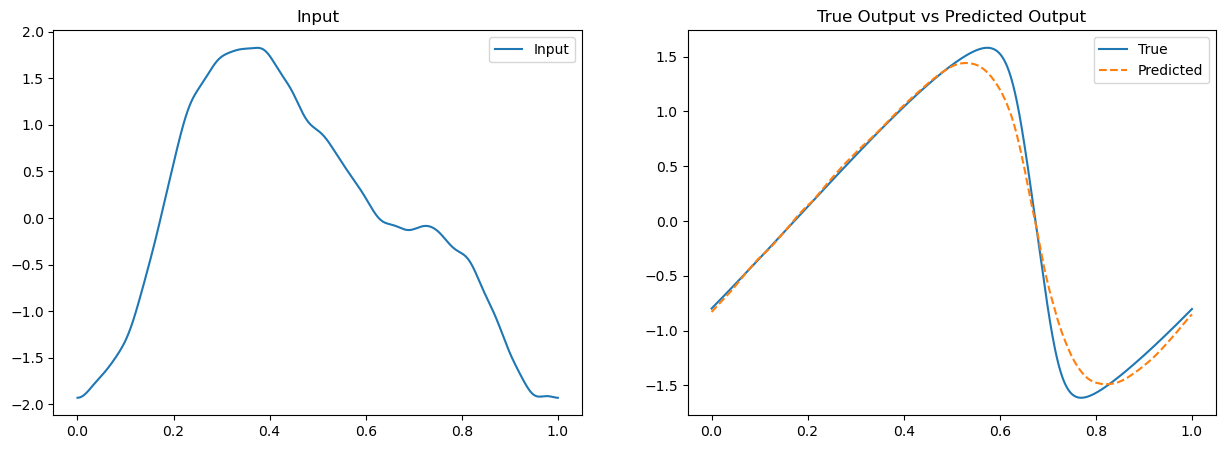

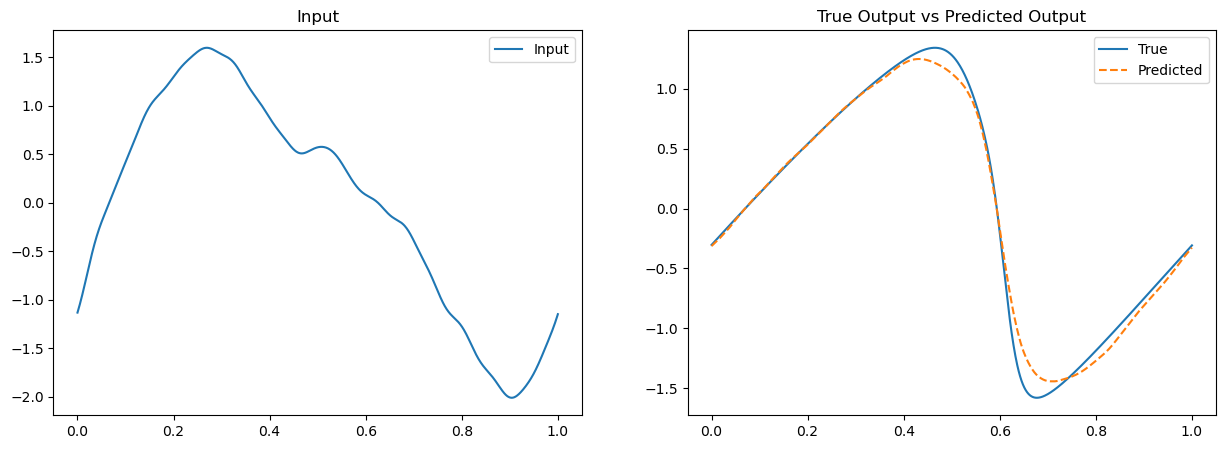

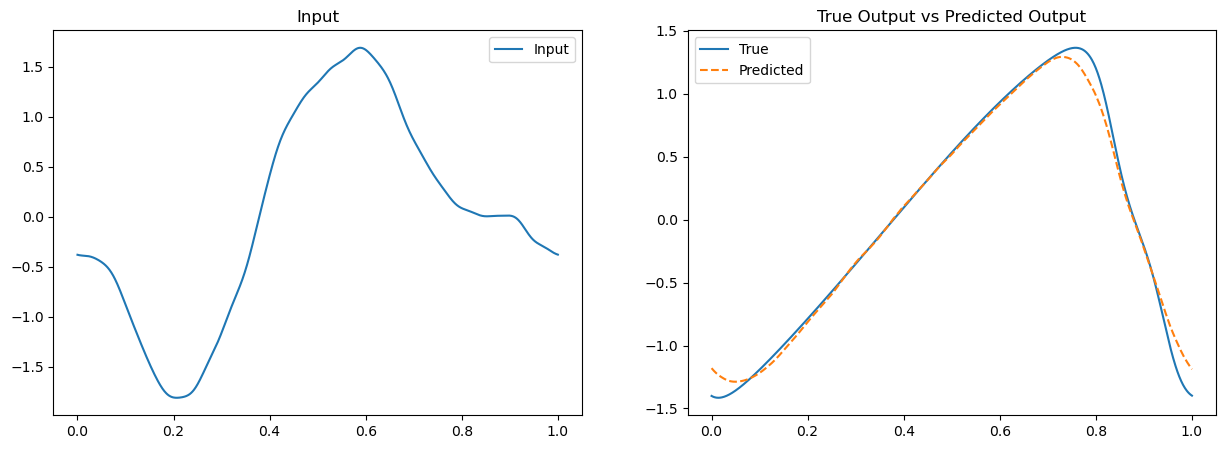

Best predictions


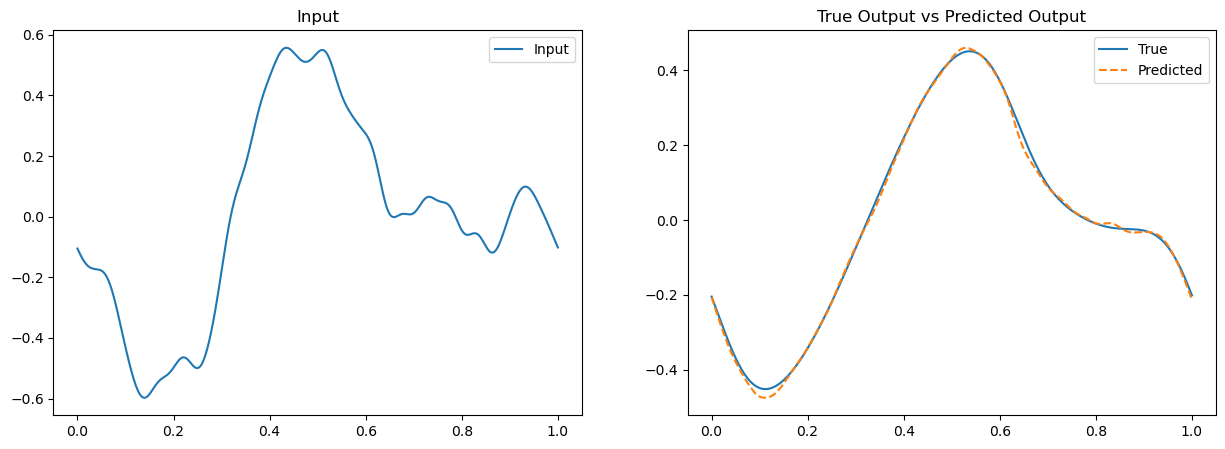

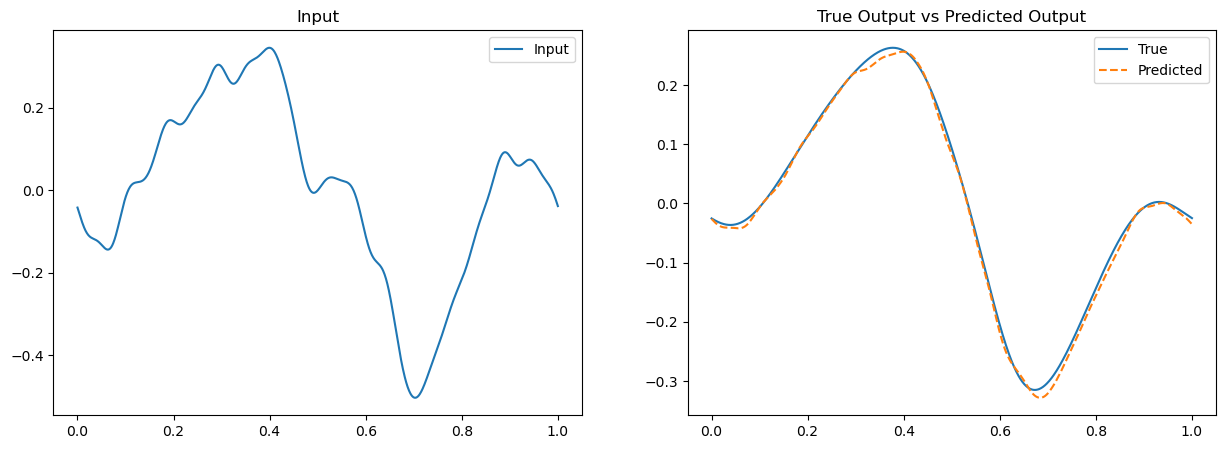

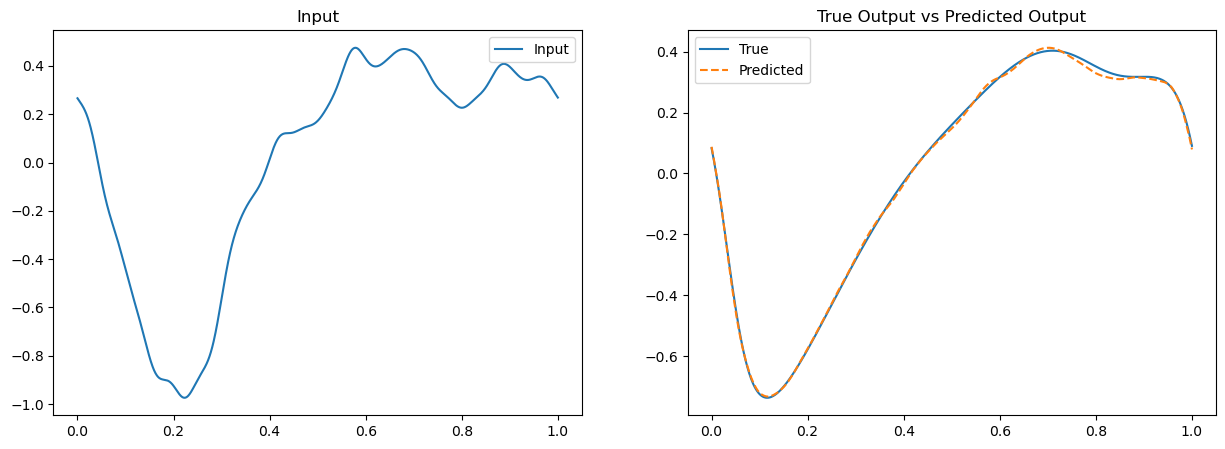

In [11]:
def evaluate_model(model, x, device):
    """Evaluate the model on test data and return the predictions on CPU."""
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        predictions = model(x)
        return predictions.cpu()

def plot_example(idx, x_test, y_test, model, device):
    """Plot the input, true output, and predicted output for a given index."""
    x = x_test[idx:idx+1, :]
    y_true = y_test[idx].numpy()
    y_pred = evaluate_model(model, x, device).view(-1).numpy()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[0, :, 1].numpy(), x[0, :, 0].numpy(), label='Input')
    plt.title('Input')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x[0, :, 1].numpy(), y_true, label='True')
    plt.plot(x[0, :, 1].numpy(), y_pred, label='Predicted', linestyle='dashed')
    plt.title('True Output vs Predicted Output')
    plt.legend()
    plt.show()

def compute_errors(model, x_test, y_test, device):
    """Compute the MSE errors for all samples in the test set."""
    y_preds = evaluate_model(model, x_test, device).view_as(y_test)
    errors = (y_preds - y_test) ** 2
    return errors.mean(dim=1).squeeze().numpy()

def plot_sorted_example(rank, x_test, y_test, sorted_indices, model, device):
    """Plot the input, true output, and predicted output for a given rank."""
    idx = sorted_indices[rank]
    plot_example(idx, x_test, y_test, model, device)

# Assume x_test, y_test, model, and other necessary data have been properly loaded and prepared
errors = compute_errors(model, x_test, y_test, device)
sorted_indices = np.argsort(errors)[::-1]

# Example: plot the test sample with the worst prediction
print('Word predictions')
plot_sorted_example(0, x_test, y_test, sorted_indices, model, device)
plot_sorted_example(1, x_test, y_test, sorted_indices, model, device)
plot_sorted_example(2, x_test, y_test, sorted_indices, model, device)
print('Best predictions')
plot_sorted_example(-3, x_test, y_test, sorted_indices, model, device)
plot_sorted_example(-2, x_test, y_test, sorted_indices, model, device)
plot_sorted_example(-1, x_test, y_test, sorted_indices, model, device)


## Analysis of the Fourier Neural Operator

Possible improvements:
- Use a single FFT and iFFT operation for the entire network.
- Modify the loss function to include physics-informed loss.
- Learn the dynamics and use NeuralODE to roll the dynamics forward in time.

Notes:
- Account for relative errors? The plots below show absolute errors, sorted, but maybe pay attention to relative errors as well.